In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 

#### wczytywanie danych
dane dzienne, trackowane raz dziennie w zakresie 1 sty 2018 do 1 sty 2020

In [2]:
dane = pd.read_csv("C:\\Users\\anton\\Desktop\\eobuwie_recruitment\\ZADANIE DOMOWE_SAMODZIELNY ANALITYK\\predykcja.csv",
                        sep = ";")
dane

,DATA,zamowienia,wyprzedaż
0,01.01.2018,100.0,NaN
1,02.01.2018,94.0,NaN
2,03.01.2018,118.0,1.0
3,04.01.2018,114.0,1.0
4,05.01.2018,122.0,1.0
...,...,...,...
1815,NaN,NaN,NaN
1816,NaN,NaN,NaN
1817,NaN,NaN,NaN
1818,NaN,NaN,NaN


In [3]:
dane.describe()

,zamowienia,wyprzedaż
count,731.000000,73.0
mean,163.822161,1.0
std,50.634155,0.0
min,86.000000,1.0
25%,120.000000,1.0
50%,152.000000,1.0
75%,211.000000,1.0
max,284.000000,1.0


In [4]:
dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATA        731 non-null    object 
 1   zamowienia  731 non-null    float64
 2   wyprzedaż   73 non-null     float64
dtypes: float64(2), object(1)
memory usage: 42.8+ KB


In [5]:
dane.isna().sum()

DATA          1089
zamowienia    1089
wyprzedaż     1747
dtype: int64

#### Czyszczenie danych

In [6]:
#dane['DATA'] = pd.to_datetime(dane['DATA'])
filled_data = dane[dane['DATA'].notnull()]
def to_dt(x):
    x = x.split(".")
    return datetime.date(int(x[2]), int(x[1]), int(x[0]))

filled_data['datedt'] = filled_data['DATA'].apply(to_dt)
filled_data

<ipython-input-6-ebae50e82d74>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filled_data['datedt'] = filled_data['DATA'].apply(to_dt)


,DATA,zamowienia,wyprzedaż,datedt
0,01.01.2018,100.0,NaN,2018-01-01
1,02.01.2018,94.0,NaN,2018-01-02
2,03.01.2018,118.0,1.0,2018-01-03
3,04.01.2018,114.0,1.0,2018-01-04
4,05.01.2018,122.0,1.0,2018-01-05
...,...,...,...,...
726,28.12.2019,260.0,NaN,2019-12-28
727,29.12.2019,257.0,NaN,2019-12-29
728,30.12.2019,257.0,NaN,2019-12-30
729,31.12.2019,254.0,NaN,2019-12-31


In [7]:
dane_sorted = filled_data.sort_values(by = "datedt")
dane_sorted.head()

,DATA,zamowienia,wyprzedaż,datedt
0,01.01.2018,100.0,NaN,2018-01-01
1,02.01.2018,94.0,NaN,2018-01-02
2,03.01.2018,118.0,1.0,2018-01-03
3,04.01.2018,114.0,1.0,2018-01-04
4,05.01.2018,122.0,1.0,2018-01-05


In [8]:
dane_sorted.set_index('datedt', inplace = True)

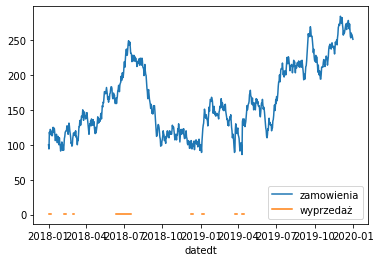

In [9]:
dane_sorted.plot() #sprawdzenie parsowania dat
plt.show()

In [10]:
dane_sorted.index.max()

datetime.date(2020, 1, 1)

In [11]:
dane_sorted.index.min()

datetime.date(2018, 1, 1)

In [12]:
# Usuniecie pustych wierszy
df = dane_sorted[dane_sorted['zamowienia'].notnull()]
df.head()

,DATA,zamowienia,wyprzedaż
datedt,,,
2018-01-01,01.01.2018,100.0,NaN
2018-01-02,02.01.2018,94.0,NaN
2018-01-03,03.01.2018,118.0,1.0
2018-01-04,04.01.2018,114.0,1.0
2018-01-05,05.01.2018,122.0,1.0


In [13]:
df["sale"] = np.where(df["wyprzedaż"] == 1, 1, 0)

#### Wizualizacja danych

Text(0.5, 1.0, 'Liczba zamowien w czasie')

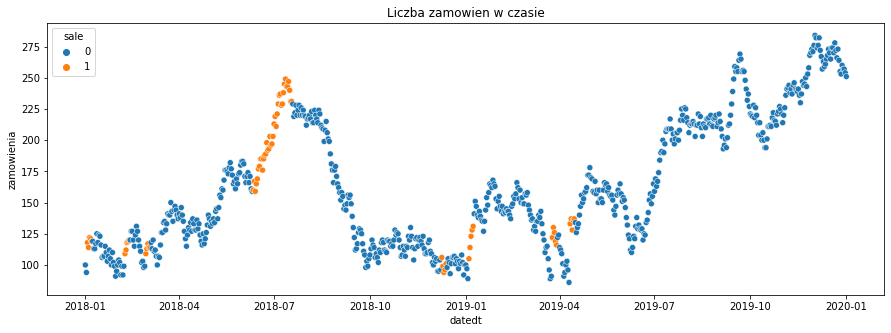

In [14]:
f, ax = plt.subplots(figsize = (15,5))
g = sns.scatterplot(
    data=df,
    x="datedt", y="zamowienia",
    hue="sale", 
    sizes=(15, 200)
)
plt.title("Liczba zamowien w czasie")

In [15]:
df.isna().sum() #ok

DATA            0
zamowienia      0
wyprzedaż     658
sale            0
dtype: int64

#### Podzielenie próbki 80-20

In [17]:
size = int(len(df)*0.8)
df_train = df.iloc[:size]
df_test = df.iloc[size:]
df_train.tail()

,DATA,zamowienia,wyprzedaż,sale
datedt,,,,
2019-08-03,03.08.2019,206.0,NaN,0
2019-08-04,04.08.2019,212.0,NaN,0
2019-08-05,05.08.2019,213.0,NaN,0
2019-08-06,06.08.2019,213.0,NaN,0
2019-08-07,07.08.2019,215.0,NaN,0


In [18]:
kopia = df_train
kopia.asfreq(freq ='D')

,DATA,zamowienia,wyprzedaż,sale
datedt,,,,
2018-01-01,01.01.2018,100.0,NaN,0
2018-01-02,02.01.2018,94.0,NaN,0
2018-01-03,03.01.2018,118.0,1.0,1
2018-01-04,04.01.2018,114.0,1.0,1
2018-01-05,05.01.2018,122.0,1.0,1
...,...,...,...,...
2019-08-03,03.08.2019,206.0,NaN,0
2019-08-04,04.08.2019,212.0,NaN,0
2019-08-05,05.08.2019,213.0,NaN,0


#### Dekompozycja szeregu czasowego 
- frequency 30

<ipython-input-19-f50a3dcca820>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(kopia['zamowienia'],


Text(0.5, 1.0, 'Trend')

<Figure size 2880x5760 with 0 Axes>

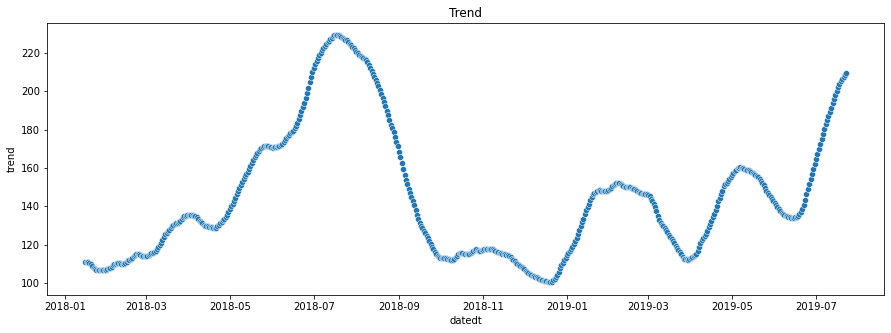

In [19]:
# ETS Decomposition 

result = seasonal_decompose(kopia['zamowienia'],  
                            model ='additive',
                           freq = 30) 
  
# ETS plot  
plt.figure(figsize=(40,80))
#result.plot() 
df1=df
df1['trend'] = result.trend
df1['seasonal'] = result.seasonal
df1['residual'] = result.resid

f, ax = plt.subplots(figsize = (15,5))
g = sns.scatterplot(
    data=df,
    x="datedt", y="trend", 
    sizes=(15, 200)
)
plt.title("Trend")

Text(0.5, 1.0, 'Seasonality')

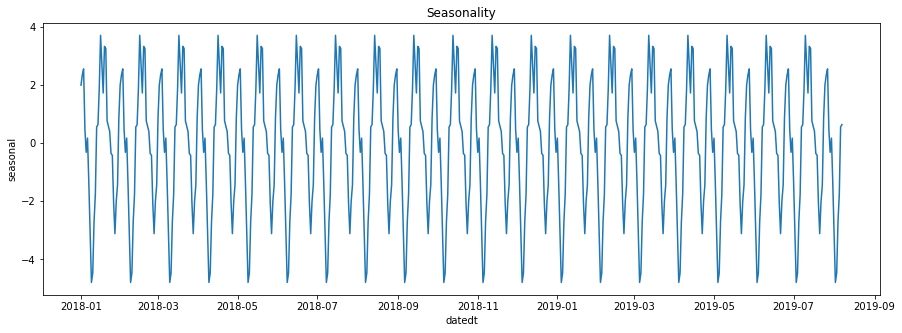

In [20]:
f, ax = plt.subplots(figsize = (15,5))
g = sns.lineplot(
    data=df1,
    x="datedt", y='seasonal', 
    sizes=(15, 200)
)
plt.title("Seasonality")

Text(0.5, 1.0, 'Residuals')

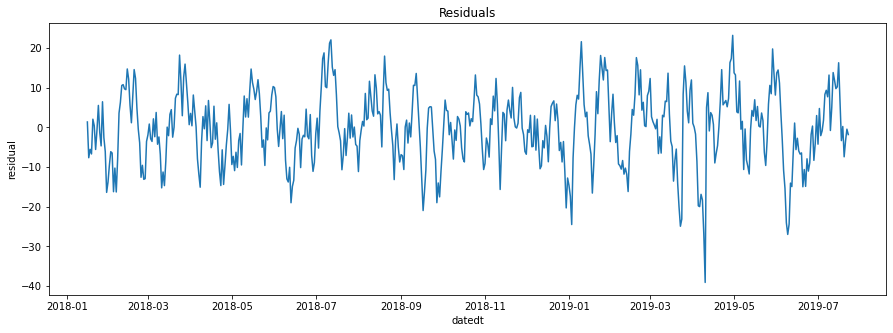

In [21]:
f, ax = plt.subplots(figsize = (15,5))
g = sns.lineplot(
    data=df1,
    x="datedt", y='residual', 
    sizes=(15, 200)
)
plt.title("Residuals")

- frequency 60

<ipython-input-22-28be4db7071f>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(kopia['zamowienia'],


<AxesSubplot:xlabel='datedt'>

<Figure size 2880x5760 with 0 Axes>

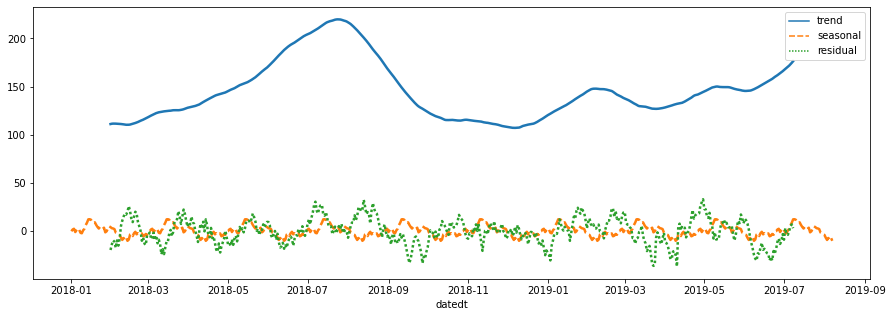

In [22]:
# ETS Decomposition 

result = seasonal_decompose(kopia['zamowienia'],  
                            model ='additive',
                           freq = 60) 
  
# ETS plot  
plt.figure(figsize=(40,80))
#result.plot() 
df1=df.copy()
df1['trend'] = result.trend
df1['seasonal'] = result.seasonal
df1['residual'] = result.resid


cols=['trend','seasonal','residual']
f, ax = plt.subplots(figsize = (15,5))
sns.lineplot(data=df1[cols], palette="tab10", linewidth=2.5)

- frequency 120

<ipython-input-23-41a18d4bec0f>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(kopia['zamowienia'],


<AxesSubplot:xlabel='datedt'>

<Figure size 2880x5760 with 0 Axes>

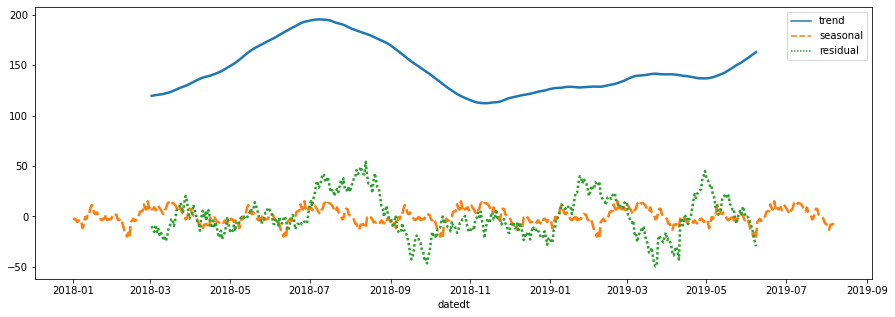

In [23]:
# ETS Decomposition 

result = seasonal_decompose(kopia['zamowienia'],  
                            model ='additive',
                           freq = 120) 
  
# ETS plot  
plt.figure(figsize=(40,80))
#result.plot() 
df1=df.copy()
df1['trend'] = result.trend
df1['seasonal'] = result.seasonal
df1['residual'] = result.resid


cols=['trend','seasonal','residual']
f, ax = plt.subplots(figsize = (15,5))
sns.lineplot(data=df1[cols], palette="tab10", linewidth=2.5)

Wnioski: dekompozycja nie wykrywa sezonowości. Trend jest zmienny, być może jest też cykliczność

### Modelowanie

przygotowanie danych

In [26]:
y = df_train['zamowienia'].values
y = y.reshape(-1,1)

In [27]:
X_sale = df_train['sale'].values
X_sale = X_sale.reshape(-1,1)

#### Wykorzystanie algorytmu stepwise arima do oszacowania hiperparametrów. Dodana binarna zmienna egzogeniczna: sale (wyprzedaż)

In [28]:

    
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(y, exogenous = X_sale,
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5113.546, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3984.813, Time=1.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4634.204, Time=1.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5117.637, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4090.356, Time=0.29 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3913.247, Time=5.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.23 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5084.202, Time=5.36 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3915.209, Time=9.14 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=3915.210, Time=7.67 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4634.177, Time=4.56 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=3917.226, Time=11.25 sec
 ARIMA(1,0,0)(2,1,0)[12]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  584
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1950.795
Date:                            Sat, 03 Oct 2020   AIC                           3911.590
Time:                                    15:48:58   BIC                           3933.336
Sample:                                         0   HQIC                          3920.073
                                            - 584                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.2595      0.952      9.725      0.000       7.393      11.126
ar.L1          0.9644      0.011     90.179      0.000       0.943       0.985
ar.S.L12      -0.5801      0.038    -15.128      0.000      -0.655      -0.505
ar.S.L24      -0.3568      0.034    -10.373      0.000      -0.424      -0.289
sigma2        52.9849      3.267     16.218      0.000      46.582      59.388
===================================================================================
Ljung-Box (Q):                       85.59   Jarque-Bera (JB):                 4.91
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               1.28   Skew:                             0.22
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Ze względu na duże różnice w naturze zjawiska w latach 2018 i 2019 - kolejna część analizy przeprowadzona zostanie w oparciu o dane z 2019

In [30]:
temp = df.copy()
temp = temp.reset_index()

In [32]:
df_2019 = temp[temp["datedt"] >= datetime.date(2019,1,1)]
df_2019i = df_2019.set_index('datedt')
size = int(len(df_2019i)*0.8)
df_train2019 = df_2019i.iloc[:size]
df_test2019 = df_2019i.iloc[size:]
df_train2019.tail()

,DATA,zamowienia,wyprzedaż,sale,trend,seasonal,residual
datedt,,,,,,,
2019-10-15,15.10.2019,194.0,NaN,0,NaN,NaN,NaN
2019-10-16,16.10.2019,194.0,NaN,0,NaN,NaN,NaN
2019-10-17,17.10.2019,201.0,NaN,0,NaN,NaN,NaN
2019-10-18,18.10.2019,211.0,NaN,0,NaN,NaN,NaN
2019-10-19,19.10.2019,211.0,NaN,0,NaN,NaN,NaN


#### Dekompozycja szeregu danych treningowych z 2019

- frequency = 30

In [35]:
result = seasonal_decompose(df_train2019['zamowienia'],  
                            model ='additive',
                           freq = 30) 
  

<AxesSubplot:xlabel='datedt'>

<Figure size 2880x5760 with 0 Axes>

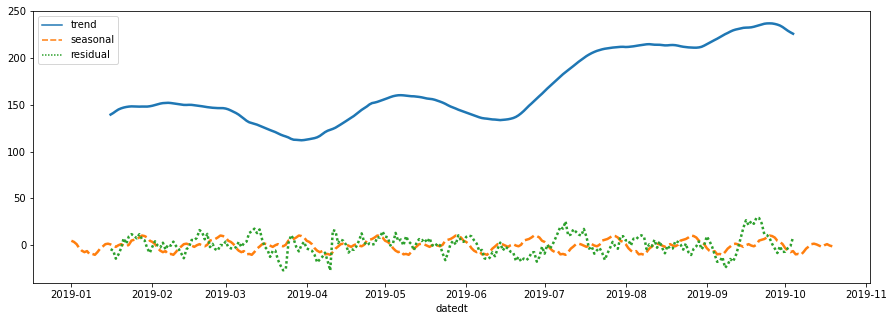

In [36]:
# ETS plot  
plt.figure(figsize=(40,80))
#result.plot() 
df1=df_train2019.copy()
df1['trend'] = result.trend
df1['seasonal'] = result.seasonal
df1['residual'] = result.resid

cols=['trend','seasonal','residual']
f, ax = plt.subplots(figsize = (15,5))
sns.lineplot(data=df1[cols], palette="tab10", linewidth=2.5)

- frequency = 60

<AxesSubplot:xlabel='datedt'>

<Figure size 2880x5760 with 0 Axes>

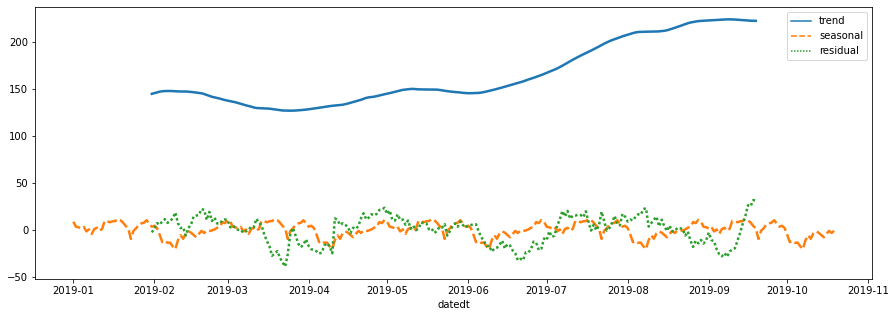

In [37]:
result = seasonal_decompose(df_train2019['zamowienia'],  
                            model ='additive',
                           freq = 60) 
  
 # ETS plot  
plt.figure(figsize=(40,80))
#result.plot() 
df1=df_train2019.copy()
df1['trend'] = result.trend
df1['seasonal'] = result.seasonal
df1['residual'] = result.resid

cols=['trend','seasonal','residual']
f, ax = plt.subplots(figsize = (15,5))
sns.lineplot(data=df1[cols], palette="tab10", linewidth=2.5)   

##### Trend wzrostowy, nadal brak wyraźnej sezownowości

### Modelowanie podejściem ARIMA z wykorzystaniem algorytmu stepwise

In [39]:
y = df_train2019['zamowienia'].values
y = y.reshape(-1,1)
X_sale = df_train2019['sale'].values
X_sale = X_sale.reshape(-1,1)

In [40]:
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(y, exogenous = X_sale,
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2592.769, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2009.600, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2338.337, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2596.487, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2054.209, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1964.592, Time=3.84 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1923.517, Time=4.89 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=1925.205, Time=5.96 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=7.04 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=1925.221, Time=5.23 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1925.239, Time=5.70 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                -954.759
Date:                              Sat, 03 Oct 2020   AIC                           1923.517
Time:                                      16:00:05   BIC                           1948.961
Sample:                                           0   HQIC                          1933.723
                                              - 292                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1659      0.107      1.545      0.122      -0.045       0.376
x1            15.0420      1.568      9.592      0.000      11.969      18.116
ar.L1          0.9695      0.015     66.312      0.000       0.941       0.998
ar.S.L12      -0.0182      0.079     -0.229      0.819      -0.174       0.137
ar.S.L24      -0.1692      0.068     -2.490      0.013      -0.302      -0.036
ma.S.L12      -0.8396      0.064    -13.099      0.000      -0.965      -0.714
sigma2        50.0556      5.091      9.833      0.000      40.078      60.033
===================================================================================
Ljung-Box (Q):                       29.56   Jarque-Bera (JB):                 3.85
Prob(Q):                              0.89   Prob(JB):                         0.15
Heteroskedasticity (H):               0.85   Skew:                             0.20
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Zestaw identycznych hiperparametrów dla modeli wytrenowanych na próbie dwuletniej i rocznej podsuwa myśl, że podejście Stepwise wpada w minimum lokalne

### Modelowanie podejściem ARIMA z wykorzystaniem algorytmu grid-search

In [43]:
gridsearch_fit = auto_arima(y, exogenous = X_sale,
                         # start_p = 2, start_q = 2, 
                          max_p = 4, max_q = 4, m = 1, 
                          start_P = 0, seasonal = False, information_criterion='aicc',
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = False)           # set to gridsearch
  
# To print the summary 
gridsearch_fit.summary() 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=1960.484, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=1962.518, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AICC=1964.576, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AICC=1966.346, Time=0.28 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AICC=1964.657, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=1962.518, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=1964.016, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=1966.026, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AICC=1966.290, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AICC=1964.675, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AICC=1964.575, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AICC=1966.648, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=1957.372, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AICC=1956.665, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AICC=1966.419, Time=0.14

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -970.078
Date:                Sat, 03 Oct 2020   AIC                           1956.156
Time:                        16:04:02   BIC                           1985.543
Sample:                             0   HQIC                          1967.928
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1535      0.214      0.718      0.473      -0.265       0.572
x1            14.6533      1.008     14.538      0.000      12.678      16.629
ar.L1          1.2907      0.133      9.701      0.000       1.030       1.551
ar.L2         -0.7050      0.121     -5.846      0.000      -0.941      -0.469
ma.L1         -1.3197      0.146     -9.047      0.000      -1.606      -1.034
ma.L2          0.7366      0.170      4.322      0.000       0.403       1.071
ma.L3          0.0906      0.082      1.110      0.267      -0.069       0.250
sigma2        45.9472      4.091     11.232      0.000      37.929      53.965
===================================================================================
Ljung-Box (Q):                       28.23   Jarque-Bera (JB):                 6.23
Prob(Q):                              0.92   Prob(JB):                         0.04
Heteroskedasticity (H):               0.90   Skew:                             0.34
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Grid-search wychodzi z hiperparametrami (2, 1, 3) jednak ma wyższą wartość AIC

### Porównianie modeli

In [45]:
y_pred = df_test2019['zamowienia'].values
y_pred = y_pred.reshape(-1,1)
X_sale_test = df_test2019['sale'].values
X_sale_test = X_sale_test.reshape(-1,1)

In [48]:
# Fit a SARIMAX(2, 1, 3) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model_grid = SARIMAX(df_train2019['zamowienia'],  exog = X_sale,
                order = (2, 1, 3), trend='c', 
               seasonal_order =(0, 0, 0, 0)) 
  
result_grid = model_grid.fit() 
result_grid.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             zamowienia   No. Observations:                  292
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -970.078
Date:                Sat, 03 Oct 2020   AIC                           1956.156
Time:                        16:07:45   BIC                           1985.543
Sample:                    01-01-2019   HQIC                          1967.928
                         - 10-19-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1535      0.214      0.718      0.473      -0.265       0.572
x1            14.6533      1.008     14.538      0.000      12.678      16.629
ar.L1          1.2907      0.133      9.701      0.000       1.030       1.551
ar.L2         -0.7050      0.121     -5.846      0.000      -0.941      -0.469
ma.L1         -1.3197      0.146     -9.047      0.000      -1.606      -1.034
ma.L2          0.7366      0.170      4.322      0.000       0.403       1.071
ma.L3          0.0906      0.082      1.110      0.267      -0.069       0.250
sigma2        45.9472      4.091     11.232      0.000      37.929      53.965
===================================================================================
Ljung-Box (Q):                       28.23   Jarque-Bera (JB):                 6.23
Prob(Q):                              0.92   Prob(JB):                         0.04
Heteroskedasticity (H):               0.90   Skew:                             0.34
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

TypeError: index type not supported

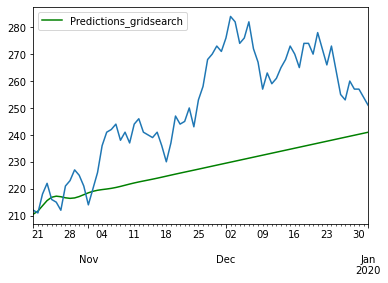

In [52]:
###
start = len(df_train2019) 
end = len(df_train2019) + len(df_test2019) - 1
  
# Predictions for one-year against the test set 
predictions_grid = result_grid.predict(start, end, exog = X_sale_test,
                             typ = 'levels').rename("Predictions_gridsearch") 
  
# plot predictions and actual values 
predictions_grid.plot(legend = True, color = 'g') 
df_test2019['zamowienia'].plot(legend = True) 

#### Predykcja w pierwszych okresach wygładza, następnie zdaje się niedoszacowywać, jednak po koniec okresu, linia actuals zbiega do prediction

In [54]:
# Fit a SARIMAX(1, 0, 0)x(2, 1, 0, 12) stepwise method on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model_st = SARIMAX(df_train2019['zamowienia'],  exog = X_sale,
                order = (1, 0, 0), #brak stalej
                seasonal_order =(2, 1, 0, 12)) 
  
result_st = model_st.fit() 
result_st.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         zamowienia   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -976.553
Date:                            Sat, 03 Oct 2020   AIC                           1963.107
Time:                                    16:12:09   BIC                           1981.281
Sample:                                01-01-2019   HQIC                          1970.396
                                     - 10-19-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            16.6320      1.532     10.856      0.000      13.629      19.635
ar.L1          0.9665      0.014     69.687      0.000       0.939       0.994
ar.S.L12      -0.5882      0.061     -9.691      0.000      -0.707      -0.469
ar.S.L24      -0.4203      0.052     -8.091      0.000      -0.522      -0.318
sigma2        60.7325      6.005     10.114      0.000      48.964      72.501
===================================================================================
Ljung-Box (Q):                       62.65   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.01   Prob(JB):                         0.06
Heteroskedasticity (H):               0.88   Skew:                             0.23
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

TypeError: index type not supported

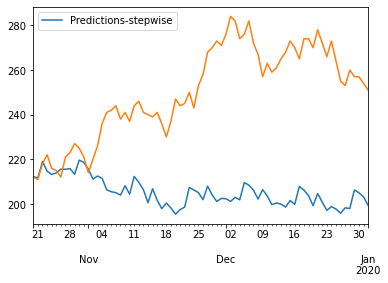

In [55]:
start = len(df_train2019) 
end = len(df_train2019) + len(df_test2019) - 1
  
# Predictions for one-year against the test set 
predictions_st = result_st.predict(start, end, exog = X_sale_test,
                             typ = 'levels').rename("Predictions-stepwise") 
  
# plot predictions and actual values 
predictions_st.plot(legend = True) 
df_test2019['zamowienia'].plot(legend = True) 

#### Predykcja ocenianiana wizualnie wydaje się bardzo niedoszacowywać. 

### Porównanie dwóch podejść

TypeError: index type not supported

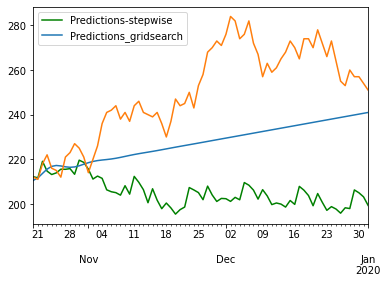

In [57]:
# plot predictions and actual values 
predictions_st.plot(legend = True, color = "g") 
predictions_grid.plot(legend = True) 
df_test2019['zamowienia'].plot(legend = True) 

#### Model Grid-search pokazuje lepsze dopasowanie

### Predykcja na styczeń i luty 2020 z użyciem podejścia grid-search

In [60]:
X_sale2019 = df_2019i['sale'].values
X_sale2019 = X_sale2019.reshape(-1,1)

#### Użycie modelu na całym zbiorze 2019

In [62]:
# Fit a SARIMAX(2, 1, 3) on the entire 2019 set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model_2019 = SARIMAX(df_2019i['zamowienia'],  exog = X_sale2019,
                order = (2, 1, 3), trend='c') 
          #      seasonal_order =(2, 1, 1, 12)) 
  
result_2019 = model_2019.fit() 
result_2019.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             zamowienia   No. Observations:                  366
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1204.550
Date:                Sat, 03 Oct 2020   AIC                           2425.101
Time:                        16:15:07   BIC                           2456.300
Sample:                    01-01-2019   HQIC                          2437.500
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1667      0.171      0.977      0.329      -0.168       0.501
x1            13.8728      0.967     14.351      0.000      11.978      15.767
ar.L1          1.3973      0.083     16.931      0.000       1.236       1.559
ar.L2         -0.8064      0.077    -10.431      0.000      -0.958      -0.655
ma.L1         -1.4189      0.097    -14.678      0.000      -1.608      -1.229
ma.L2          0.8218      0.123      6.655      0.000       0.580       1.064
ma.L3          0.0674      0.066      1.027      0.304      -0.061       0.196
sigma2        42.9827      3.343     12.859      0.000      36.431      49.534
===================================================================================
Ljung-Box (Q):                       30.43   Jarque-Bera (JB):                 8.59
Prob(Q):                              0.86   Prob(JB):                         0.01
Heteroskedasticity (H):               0.69   Skew:                             0.34
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Uwaga - w próbie jest już 1 stycznia 2020

In [63]:
df.tail()

,DATA,zamowienia,wyprzedaż,sale,trend,seasonal,residual
datedt,,,,,,,
2019-12-28,28.12.2019,260.0,NaN,0,NaN,NaN,NaN
2019-12-29,29.12.2019,257.0,NaN,0,NaN,NaN,NaN
2019-12-30,30.12.2019,257.0,NaN,0,NaN,NaN,NaN
2019-12-31,31.12.2019,254.0,NaN,0,NaN,NaN,NaN
2020-01-01,01.01.2020,251.0,NaN,0,NaN,NaN,NaN


In [65]:
df['zamowienia'].values[-1]

251.0

In [66]:
X_sale2020 = np.zeros(30+28)
X_sale2020 = X_sale2020.reshape(-1,1)

#### Scenariusz 1: nie planujemy wyprzedaży

<AxesSubplot:>

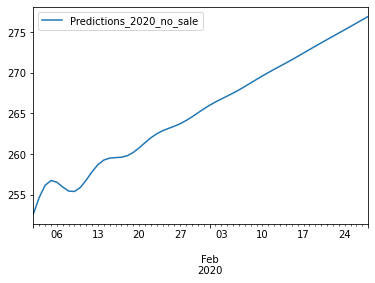

In [68]:
###
start = len(df_2019i) 
end = len(df_2019i) + 30+28- 1
  
# Predictions for one-year against the test set 
predictions_2020_no_sale = result_2019.predict(start, end, exog = X_sale2020,
                             typ = 'levels').rename("Predictions_2020_no_sale") 
  
# plot predictions and actual values 
predictions_2020_no_sale.plot(legend = True) 

##### Prognozowana liczba zamówień na styczeń 2020 - bez 01.01.2020 (jest już w danych)

In [71]:
sum(predictions_2020_no_sale[:30]) # bez 1.sty. bo był w danych

7789.905836441063

##### Prognozowana liczba zamówień na luty 2020

In [72]:
sum(predictions_2020_no_sale[30:])

7599.422390404141

#### Scenariusz 2: wyprzedaż planowana w terminie 1 -7.02.2020

In [69]:
X_sale2020_Feb = np.array([0.0]*30 + [1.0]*7 + [0.0]*21)
X_sale2020_Feb = X_sale2020_Feb.reshape(-1,1)

<AxesSubplot:>

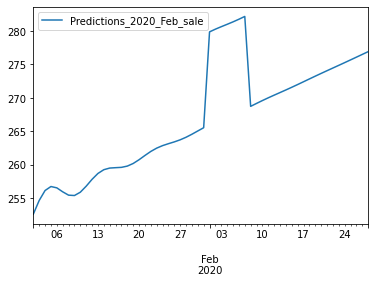

In [70]:
start = len(df_2019i) 
end = len(df_2019i) + 30+28- 1
  
# Predictions for one-year against the test set 
predictions_2020_Feb_sale = result_2019.predict(start, end, exog = X_sale2020_Feb,
                             typ = 'levels').rename("Predictions_2020_Feb_sale") 
  
# plot predictions and actual values 
predictions_2020_Feb_sale.plot(legend = True) 

##### Prognozowana liczba zamówień na styczeń 2020 - bez 01.01.2020 (jest już w danych)

In [74]:
sum(predictions_2020_Feb_sale[:30])

7789.905836441063

##### Prognozowana liczba zamówień na luty 2020 z uwzględnieniem wyprzedaży

In [76]:
sum(predictions_2020_Feb_sale[30:])

7696.531702655219